In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [256]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/6a/49/7e10686647f741bd9c8918b0decdb94135b542fe372ca1100739b8529503/xgboost-0.82-py2.py3-none-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d7/b1/3367ea1f372957f97a6752ec725b87886e12af1415216feec9067e31df70/numpy-1.16.5-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1d/f6/7c16d60aeb3694e5611976cb4f1eaf1c6b7f1e7c55771d691013405a02ea/scipy-1.2.2-cp27-cp27mu-manylinux1_x86_64.whl


In [151]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix, classification_report,precision_recall_curve
from sklearn import preprocessing


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [181]:
df = pd.read_csv('./input/Train_dt_v3.csv')

In [9]:
def drop_col(df,columns):
    df.drop(columns=columns, axis=1, inplace=True)
    return df

In [184]:
df = drop_col(df,['Col1'])

In [81]:
df_0 =  df[df['Col2'] == 0]

In [82]:
df_1 = df[df['Col2'] == 1]
df_1.head()

In [219]:
def getX_and_Y(df):
    Y = df['Col2'].to_numpy()
    X = df[df.columns.difference(['Col2'])].to_numpy()


    return X, Y




In [222]:
X_0, Y_0 = getX_and_Y(df_0)

In [221]:
X_1, Y_1 = getX_and_Y(df_1)

In [223]:
full_X, full_Y = getX_and_Y(df)

(200, 2171)
(200,)


In [242]:
def sample_and_preprocess_data(df):
    
    Y = df['Col2'].to_numpy()
    X = df[df.columns.difference(['Col2'])].to_numpy()
    X_transformed = transformer.transform(X)
    X_train, X_val, Y_train, Y_val = train_test_split(X_transformed,Y, test_size=0.20, random_state=42, stratify=Y)
    print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
    return X_val, Y_val
    

In [243]:
X_actual, Y_actual = sample_and_preprocess_data(df)

(14016, 2171) (3505, 2171) (14016,) (3505,)


In [226]:
def normalize_train_X(X):
    scaler = preprocessing.MinMaxScaler()
    X_transformed = scaler.fit_transform(X)
    return X_transformed, scaler

In [227]:
X_transformed, transformer = normalize_train_X(full_X)

In [229]:
X_0_transformed = transformer.transform(X_0)

In [230]:
X_train, X_val, Y_train, Y_val = train_test_split(X_0_transformed,Y_0, test_size=0.10, random_state=42, stratify=Y)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(14184, 2171) (1576, 2171) (14184,) (1576,)


In [231]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


In [232]:
X_train.shape

(14184, 2171)

In [233]:
input_shape = X_train.shape[1]

In [247]:
def basic_model(input_shape):
    learning_rate = 0.001
    input_img = Input(shape=(input_shape,))
    encoded = Dense(1024,  activation='relu', activity_regularizer=regularizers.l1(learning_rate))(input_img)
    encoded = Dense(512, activation='relu')(encoded)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(1024, activation='relu')(decoded)
    decoded = Dense(input_shape, activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [248]:
autoencoder = basic_model(input_shape)

In [249]:
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(X_val, X_val),
                verbose=1) 

Train on 14184 samples, validate on 1576 samples
Epoch 1/10
14184/14184 [==============================] - 25s 2ms/sample - loss: 0.0309 - val_loss: 0.0203
Epoch 2/10
14184/14184 [==============================] - 22s 2ms/sample - loss: 0.0202 - val_loss: 0.0195
Epoch 3/10
14184/14184 [==============================] - 23s 2ms/sample - loss: 0.0198 - val_loss: 0.0189
Epoch 4/10
14184/14184 [==============================] - 21s 2ms/sample - loss: 0.0188 - val_loss: 0.0180
Epoch 5/10
14184/14184 [==============================] - 24s 2ms/sample - loss: 0.0184 - val_loss: 0.0177
Epoch 6/10
14184/14184 [==============================] - 22s 2ms/sample - loss: 0.0183 - val_loss: 0.0179
Epoch 7/10
14184/14184 [==============================] - 23s 2ms/sample - loss: 0.0183 - val_loss: 0.0181
Epoch 8/10
14184/14184 [==============================] - 23s 2ms/sample - loss: 0.0181 - val_loss: 0.0184
Epoch 9/10
14184/14184 [==============================] - 23s 2ms/sample - loss: 0.0181 - val_l

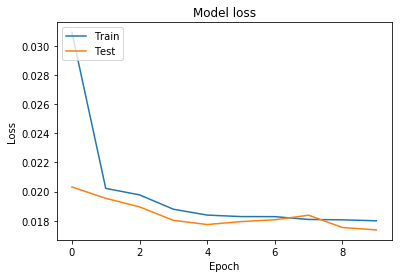

In [250]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [238]:
def accuracy(Y_test, predictions):
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [239]:
def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true), axis=-1 )

def reconstruction_loss(X_test):
    y_pred = autoencoder.predict(X_test)
    print(X_test.shape,y_pred.shape)
    loss = mse(X_test, y_pred)
    return loss

def plot_sample(loss, plt, title):


    plt.plot(loss)
    plt.set_ylabel('Loss')
    plt.set_xlabel('Epoch')
   

(1576, 2171) (1576, 2171)
0.01530283733140768 0.03450902049690538


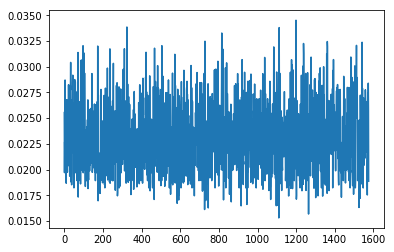

In [251]:
X_val_transformed = transformer.transform(X_val)
X_val_loss = reconstruction_loss(X_val_transformed)
plt.plot(X_val_loss)
print(np.min(X_val_loss), np.max(X_val_loss))

(1761, 2171) (1761, 2171)


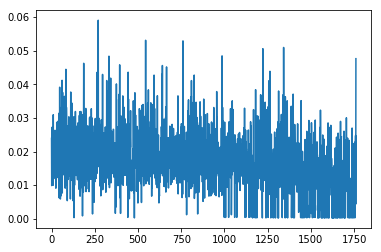

In [252]:
X_1_transformed = transformer.transform(X_1)
X_1_loss = reconstruction_loss(X_1_transformed)
plt.plot(X_1_loss)

In [253]:
np.min(X_1_loss), np.max(X_1_loss)

(0.0002309163937719225, 0.05907563268808556)

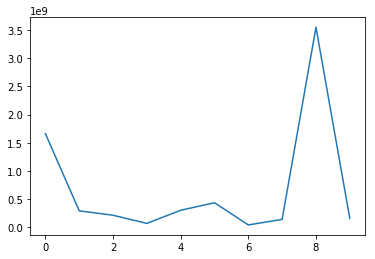

In [196]:
X_val_loss = reconstruction_loss(X_actual[0:100])

(100, 2171) (100, 2171)


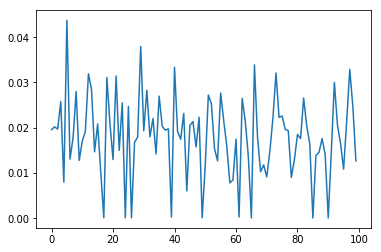

In [197]:
plt.plot(X_val_loss)

In [153]:
 Y_val[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


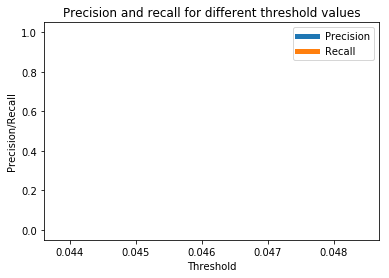

In [152]:
error_df = pd.DataFrame({'Reconstruction_error': X_val_loss,
                        'True_class': Y_val[0:100]})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [254]:
def predict_and_test(X_test, Y_test):
    threshold_fixed = 0.03
    mse = reconstruction_loss(X_test)
    print(mse)
    error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test})
    error_df_test = error_df_test.reset_index()
    Y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, Y_pred)
    print(conf_matrix)
    print(f1_score(error_df.True_class, Y_pred))
    print(classification_report(error_df.True_class, Y_pred))
    return error_df_test, Y_pred

In [255]:
X_actual_transformed = transformer.transform(X_actual)
error_df, Y_pred = predict_and_test(X_actual, Y_actual)

(3505, 2171) (3505, 2171)
[0.01865957 0.02083332 0.01647103 ... 0.01895703 0.01509254 0.02033939]
[[2744  409]
 [ 303   49]]
0.12098765432098765
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3153
           1       0.11      0.14      0.12       352

    accuracy                           0.80      3505
   macro avg       0.50      0.50      0.50      3505
weighted avg       0.82      0.80      0.81      3505



In [195]:
error_df.head()

,index,Reconstruction_error,True_class
0,0,0.019598,0
1,1,0.020204,0
2,2,0.019720,0
3,3,0.025768,1
4,4,0.008003,1


In [59]:
test_df = pd.read_csv("./input/Test_Cleaned.csv")

In [60]:
id_series = test_df['Col1']

In [61]:
submission_df = pd.DataFrame({'Col1':id_series}) 

In [36]:
test_df = drop_col(test_df, ['Col1'])

In [50]:
test_df =  test_df.reindex(sorted(test_df.columns), axis=1)

In [51]:
test_df.head()

,Col10,Col100,Col1000,Col1001,Col1002,Col1003,Col1004,Col1005,Col1006,Col1007,...,Col990,Col991,Col992,Col993,Col994,Col995,Col996,Col997,Col998,Col999
0,3.053853e+04,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.147556e+07,0.000000,4,2,3,2,3,2,0,0,...,0,0,2,1,4,2,3,2,4,1
2,3.904086e+05,2.000000,3,2,0,0,1,0,2,1,...,0,0,0,0,2,3,2,2,2,1
3,8.650108e+04,1.864248,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,2.528307e+05,0.000000,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [52]:
sub_pred = xg_boost_predit(model, test_df)

In [63]:
submission_df['Col2'] = pd.Series(sub_pred)

In [64]:
submission_df.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0


In [65]:
submission_df.to_csv("submission_v1.csv", index=False, header=True)

In [66]:
submission_df.groupby('Col2').count()

,Col1
Col2,
0,18869
1,1573
